# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Авторы материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий, магистрант ВМК МГУ Евгений Колмаков
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Урок 4. Обучение с учителем. Ансамбли классификаторов
## Часть 1. Bagging

Одним из простых вариантов построения композиции алгоритмов классификации является bagging (bootstrap aggregating). Он основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей. 

Метод бутстрэппинга заключается в следующем. Пусть имеется выборка $X$ размера $N$. Равномерно возьмем из выборки $N$ объектов с возвращением. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $X_1$. Повторяя процедуру $M$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

Например, предположим, что мы хотим оценить средний вес среди всех людей в мире. У нас нет возможности взвесить всех людей, но мы можем взять небольшую выборку размера $N$ и взвесить всех этих людей. По такой выборке мы можем только оценить среднее. Однако чтобы делать выводы и генеральной совокупности, нам необходимо больше информации и разбросе среднего, как если бы мы оценили средний вес по нескольким таким выборкам.

С помощью бутстрэпа мы можем получить большое число выборок, каждая из которых является выборкой с возвращением из нашей исходной выборки, и по каждой из них оценить средний вес. По этим оценкам мы можем построить гистограмму таких средних, которая позволяет оценить форму распределения среднего веса. Рассмотрим пример:

Populating the interactive namespace from numpy and matplotlib


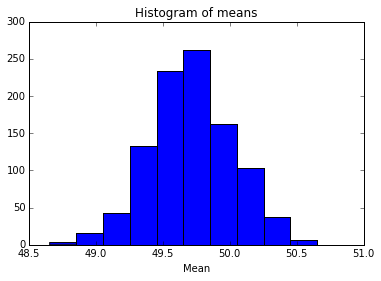

In [1]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from sklearn.utils import resample

N = 1000 # Sample size
M = 1000 # Number of bootstrap samples
X = 50.0 + 10 * np.random.randn(N) # Initial sample

# Resampling M times with replacement from X and estimating mean every time
means = [np.mean(resample(X)) for i in range(M)] 
    
plt.hist(means)
plt.title('Histogram of means')
plt.xlabel('Mean')

Перейдём к бэггингу. Пусть имеется обучающая выборка $X$. С помощью бутстрэппинга сгенерируем из неё выборки $X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Общая схема бэггинга выглядит так: 
<center>
<img src="..\img\bagging.png" width="500">
</center>

Бэггинг позволяет снизить разброс (variance) обучаемого классификатора, тем самым помогая в борьбе с переобучением. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.

## Random subspace method (attribute bagging)
Метод случайных подпространств аналогичен бэггингу, однако базовые алгоритмы теперь обучаются на полной выборке, но используя только случайно выбранное подмножество признаков. Данный метод эффективен в задачах с большим числом признаков и небольшим числом объектов, а также при наличии неинформативных признаков. В этих случаях классификаторы, построенные по части признакового описания, могут обладать лучшей обобщающей способностью по сравнению с классификаторами, построенными с использованием всех признаков.

## Random patching
Данный метод является комбинацией бэггинга и метода случайных подпространств: каждый базовый классификатор обучается, используя подвыборку, сгенерированную с помощью бутстрэппинга, на случайном подмножестве признаков.

## Примеры
Все описанные выше методы реализованы классом sklearn.ensemble.BaggingClassifier (или BaggingRegressor для задач восстановления регрессии). Параметры max_samples и max_features указывают число (или долю) объектов и признаков для случайного выбора, параметр bootstrap указывает на то, будет ли выборка генерироваться с возвращением или без, аналогично bootstrap_features для признаков.

В качестве примера рассмотрим задачу восстановления одномерной регрессии с помощью DecisionTreeRegressor.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


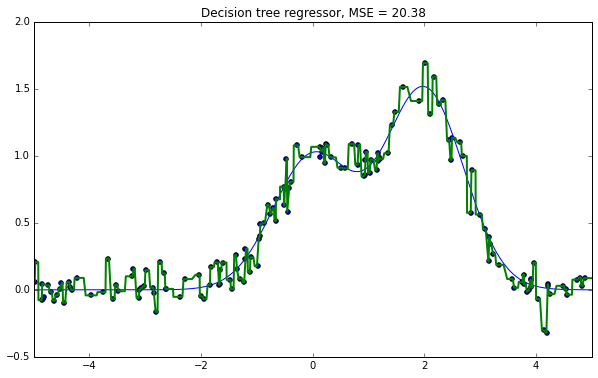

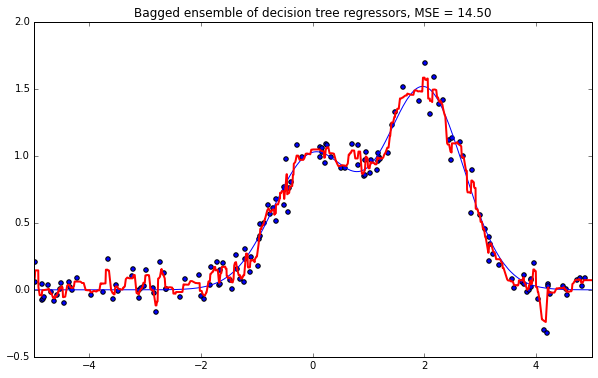

In [2]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor()

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - d_predict) ** 2))
plt.show()

# Bagging
btree = BaggingRegressor(DecisionTreeRegressor(), 
                         n_estimators=100) # max_samples = 1.0, bootstrap = True, 
                                        # max_features 1.0, bootstrap_features = False  
btree.fit(X_train, y_train)
b_predict = btree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, b_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Bagged ensemble of decision tree regressors, MSE = %.2f" % 
          np.sum((y_test - b_predict) ** 2))

Как видно, взвешивание различных деревьев, обученных по разным подвыборкам, даёт лучший результат по сравнению с использованием одного дерева.

Рассмотрим пример использования метода Random patching в задаче классификации. В качестве базового алгоритма возьмём алгоритм SVM с RBF-ядром.

In [3]:
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import sys
if sys.version_info.major == 2:
    from urllib import urlopen
if sys.version_info.major == 3:    
    from urllib.request import urlopen
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import train_test_split

# Loading Pima Indians Diabetes data from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], data[:, 8], random_state=0)

C = 100.0
gamma = 0.001

lin_svm = SVC(C=C, gamma=gamma).fit(X_train, y_train)

# Random patching
bag_svm = BaggingClassifier(SVC(C=C, gamma=gamma), 
                            max_samples=0.8, max_features=5,
                            n_estimators=100, random_state=0).fit(X_train, y_train)

print("One SVM accuracy: %.2f" % lin_svm.score(X_test, y_test))
print("Random patching of SVMs accuracy: %.2f" % bag_svm.score(X_test, y_test))

One SVM accuracy: 0.67
Random patching of SVMs accuracy: 0.77


## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Bootstrapping_(statistics)">Bootstrapping</a>
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации